# Loading Dependencies
---

In [1]:
import sys

try:        
    from google.colab import drive
    drive.mount('/content/gdrive')

    !pip install yfinance
    !pip install pdfplumber
    !rm -rf github
    !mkdir github
    !cd github && git clone https://github.com/dr315/Finances.git
    sys.path.append('/content/github/Finances')
    
    root = '/content/gdrive/MyDrive/'    
except:
    root = 'd:/'

import pandas as pd
pd.options.display.float_format = '${:,.2f}'.format
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from FinanceTools import *
from OrdersReader import *    


# Loading and formating table
----

In [2]:
df = pd.read_csv(root + '/Investing/Notas_TD/transactions.csv')
df=df[~df['DATE'].str.contains('END OF FILE')].fillna(0)
df['TYPE'] = 'STOCK'
df['DATE'] = pd.to_datetime(df['DATE']).dt.strftime('%Y-%m-%d')
df = df[['SYMBOL', 'DATE', 'PRICE', 'QUANTITY', 'DESCRIPTION', 'TYPE', 'COMMISSION', 'AMOUNT']]
def DescriptionParser(row):
    desc = row['DESCRIPTION']
    if ('Bought' in desc):
        row['DESCRIPTION'] = 'B'
    if ('Sold' in desc):
        row['DESCRIPTION'] = 'S'
    if ('WIRE' in desc):
        row['DESCRIPTION'] = 'W'
        row['SYMBOL'] = 'CASH'
        row['QUANTITY'] = 1
        row['PRICE'] = row['AMOUNT']
    return row

df = df.apply(DescriptionParser, axis=1)
df = df.rename(columns={'DESCRIPTION':'OPERATION'})
df.to_csv(root + '/Investing/TD.csv', index=False)

In [3]:
df = pd.read_csv(root + '/Investing/TD.csv')
  
df = df.iloc[:, :7]
df.columns=['SYMBOL','DATE', 'PRICE', 'QUANTITY', 'OPERATION', 'TYPE', 'FEE']
#drop empty lines
df=df[df['DATE'].astype(bool)].dropna()
brTickers = np.sort(df[df['TYPE'].isin(['FII','Ação'])]['SYMBOL'].unique()).tolist()
usTickers = np.sort(df[df['TYPE'].isin(['STOCK', 'REIT'])]['SYMBOL'].unique()).tolist()

if(df['PRICE'].apply(type).eq(str).any()): 
    df['PRICE'] = df['PRICE'].str.replace(',', '')
    df['PRICE'] = pd.to_numeric(df['PRICE'], errors='coerce')
    df['QUANTITY'] = pd.to_numeric(df['QUANTITY'], errors='coerce')
    df['FEE'] = pd.to_numeric(df['FEE'], errors='coerce')

if(df['DATE'].apply(type).eq(str).any()): 
    df['DATE'] = df.DATE.str.replace('-','/')
    df['DATE'] = pd.to_datetime(df['DATE'], format='%Y/%m/%d')
df['Year'] = pd.DatetimeIndex(df['DATE']).year
df['Month'] = pd.DatetimeIndex(df['DATE']).month_name()

#Sort the table by date and Type and reset index numeration
df.sort_values(by=['DATE', 'OPERATION'], ascending=[True, True], inplace=True)
df.reset_index(drop=True, inplace=True)

#turn all sell amount negative
df.loc[df.OPERATION == 'S', ['QUANTITY']] *= -1

#Get the oldest order date
startDate = df.iloc[0]['DATE']

df['AMOUNT'] = df['PRICE'] * df['QUANTITY'] 


In [4]:
# import concurrent.futures
import time
import threading
start_time = time.time()

prcReader = PriceReader(brTickers, usTickers, startDate)
splReader = SplitsReader(df)
divReader = DividendReader(df)
# divReader = YfinanceReader(df)

def threadExecutor(obj):
    obj.load()

threadList = []
threadList.append(threading.Thread(target=threadExecutor, args=(prcReader,)))
threadList.append(threading.Thread(target=threadExecutor, args=(splReader,)))
threadList.append(threading.Thread(target=threadExecutor, args=(divReader,)))

for td in threadList:
    td.start()

for td in threadList:
    td.join()

print("Executed in %s seconds" % (time.time() - start_time))

Executed in 11.764430522918701 seconds


In [5]:
dfBak = df

In [27]:
df=dfBak
df['acum_qty'] = 0
df['PM'] = 0
df['CASH'] = 0
# Clear operation costs befere 2019
# df.FEE.update(df.apply(clear2018Cost, axis=1))
df.head(1)

,SYMBOL,DATE,PRICE,QUANTITY,OPERATION,TYPE,FEE,Year,Month,AMOUNT,acum_qty,PM
0,CASH,2021-04-05,$859.16,$1.00,W,STOCK,$0.00,2021,April,$859.16,0,0


## Accumulator

In [28]:

for paper in (brTickers + usTickers):
  paperTable = df[df.SYMBOL == paper]
  fromDate = paperTable.iloc[0]['DATE']  
  toDate = dt.datetime.today().strftime('%Y-%m-%d')

  divTable = divReader.getPeriod(paper,fromDate, toDate)
  divTable['QUANTITY'] = 0
  divTable['OPERATION'] = 'DIVIDENDS'
  divTable['TYPE'] = paperTable.iloc[0]['TYPE']
  divTable['FEE'] = 0
  divTable['Year'] = pd.DatetimeIndex(divTable.index).year
  divTable['Month'] = pd.DatetimeIndex(divTable.index).month_name()
  divTable['AMOUNT'] = 0
  divTable['acum_qty'] = 0
  divTable['CASH'] = 0
  df = df.append(divTable.reset_index(drop=True))

  splitTable = splReader.getPeriod(paper,fromDate, toDate)
  splitTable['PRICE'] = 0
  splitTable['OPERATION'] = 'SPLIT'
  splitTable['TYPE'] = paperTable.iloc[0]['TYPE']
  splitTable['FEE'] = 0
  splitTable['Year'] = pd.DatetimeIndex(splitTable.index).year
  splitTable['Month'] = pd.DatetimeIndex(splitTable.index).month_name()
  splitTable['AMOUNT'] = 0
  splitTable['acum_qty'] = 0
  splitTable['CASH'] = 0
  df = df.append(splitTable.reset_index(drop=True))

df.sort_values(['DATE', 'OPERATION'], inplace=True)

#Create obj
ta = TableAccumulator()
#Calc the average price and rename the columns names
df=df.groupby(['SYMBOL']).apply(ta.ByGroup).reset_index(drop=True).dropna()
df.sort_values(['DATE', 'OPERATION'], inplace=True)

In [30]:
df[df.SYMBOL.str.contains('CASH')]

,SYMBOL,DATE,PRICE,QUANTITY,OPERATION,TYPE,FEE,Year,Month,AMOUNT,acum_qty,PM,acumProv
0,CASH,2021-04-05,$859.16,$1.00,W,STOCK,$0.00,2021,April,$859.16,$0.00,$0.00,0
15,CASH,2021-04-12,$500.00,$1.00,W,STOCK,$0.00,2021,April,$500.00,$0.00,$0.00,0
18,CASH,2021-04-19,$500.00,$1.00,W,STOCK,$0.00,2021,April,$500.00,$0.00,$0.00,0
20,CASH,2021-04-22,$535.99,$1.00,W,STOCK,$0.00,2021,April,$535.99,$0.00,$0.00,0
26,CASH,2021-04-30,$550.21,$1.00,W,STOCK,$0.00,2021,April,$550.21,$0.00,$0.00,0


# Realized Profit


## Processing

In [9]:
def CalcProfit(dtf):
    profit = Profit()
    dtf.sort_values(by=['DATE', 'OPERATION'], ascending=[True, True], inplace=True)
    dtf.reset_index(drop=True)
    return dtf.groupby(['SYMBOL', 'DATE']).apply(profit.Trade).reset_index(drop=True)


In [10]:
df = CalcProfit(df)
rl = df[df.OPERATION == 'S'][['DATE', 'SYMBOL', 'TYPE', 'Profit',	'DayTrade']]
rl['DATE'] = rl['DATE'].apply(lambda x: x.strftime('%Y-%m-%d'))
rl.loc['Total', 'Profit'] = rl['Profit'].sum()
rl.fillna(' ', inplace=True)
rl.style.applymap(color_negative_red, subset=['Profit']).format( {'Profit': 'R$ {:,.2f}', 'DayTrade': '{}'})


,DATE,SYMBOL,TYPE,Profit,DayTrade
Total,,,,R$ 0.00,


# Portifolio


In [11]:

Portifolio(prcReader,df).show()


,PM,PRICE,QUANTITY,COST,MKT_VALUE,DIVIDENDS,Rentabilidade,Lucro,%R,%R+d,Alocacao
Ativo,,,,,,,,,,,
CCJ,R$ 17.57,R$ 16.81,5,R$ 87.83,R$ 84.05,R$ 0.00,R$ -3.78,R$ -3.78,-4.31%,-4.31%,4.15%
CSCO,R$ 52.01,R$ 50.91,1,R$ 52.01,R$ 50.91,R$ 0.00,R$ -1.10,R$ -1.10,-2.11%,-2.11%,2.51%
EA,R$ 141.50,R$ 142.08,1,R$ 141.50,R$ 142.08,R$ 0.00,R$ 0.58,R$ 0.58,0.41%,0.41%,7.01%
HOLI,R$ 12.65,R$ 13.56,6,R$ 75.90,R$ 81.36,R$ 0.00,R$ 5.46,R$ 5.46,7.19%,7.19%,4.02%
INVA,R$ 12.27,R$ 11.45,6,R$ 73.62,R$ 68.70,R$ 0.00,R$ -4.92,R$ -4.92,-6.68%,-6.68%,3.39%
LAKE,R$ 28.30,R$ 28.21,2,R$ 56.60,R$ 56.42,R$ 0.00,R$ -0.18,R$ -0.18,-0.32%,-0.32%,2.78%
LI,R$ 19.48,R$ 19.74,7,R$ 136.36,R$ 138.18,R$ 0.00,R$ 1.82,R$ 1.82,1.33%,1.33%,6.82%
LUMN,R$ 12.72,R$ 12.83,10,R$ 127.20,R$ 128.30,R$ 0.00,R$ 1.10,R$ 1.10,0.86%,0.86%,6.33%
NEM,R$ 62.83,R$ 62.41,2,R$ 125.66,R$ 124.82,R$ 0.00,R$ -0.84,R$ -0.84,-0.67%,-0.67%,6.16%


# Performance Blueprint

In [12]:

p = PerformanceBlueprint(prcReader, df, dt.datetime.today().strftime('%m-%d-%Y'))
PerformanceViewer(p.calc()).show()


,Value R$,%C
Item,,
Equity,"2,026.22",100.2%
Cost,"2,022.23",100.0%
Expenses,0.00,0.0%
Paper profit,3.99,0.2%
Realized profit,0.00,0.0%
Dividends,0.00,0.0%
Total Profit,3.99,0.2%


# Taxation


In [13]:
profitLossDF = df.loc[df['Profit'] != 0]
tx = Taxation(profitLossDF)

## FII

### Swing Trade

In [14]:
tx.Process('FII')
try:
    display(tx.swingTradeTable)
except:
  print('Not avalilable')

Not avalilable


### Day Trade

In [15]:
try:
  display(tx.dayTradeTable)
except:
  print('Not avalilable')

Not avalilable


## Stocks


### Swing Trade

In [16]:
tx.Process('Ação')
try:
    display(tx.swingTradeTable)
except:
  print('Not avalilable')    

Not avalilable


### Day Trade

In [17]:
try:
  display(tx.dayTradeTable)
except:
  print('Not avalilable')

Not avalilable


# Plots

In [18]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
items = brTickers + usTickers
 
stock_picker = widgets.Dropdown(options=items, value=items[0])
stock_picker

Dropdown(options=('CASH', 'CCJ', 'CSCO', 'EA', 'HOLI', 'INVA', 'LAKE', 'LI', 'LUMN', 'NEM', 'NFLX', 'PRDO', 'T…

## Historical profitability

In [19]:
periodPicker = widgets.Dropdown(options=['1 year', '2 years', 'All'], value='1 year')
periodPicker


Dropdown(options=('1 year', '2 years', 'All'), value='1 year')

In [20]:
startPlot = startDate
frequency = 'SM'

if(periodPicker.value != 'All'):
    frequency = 'W'  
    days = int(periodPicker.value.split(' ')[0]) * 365
    wishedStart = dt.datetime.today() - pd.Timedelta(days, unit='d')
    if(pd.to_datetime(startPlot) < pd.to_datetime(wishedStart)):
      startPlot = wishedStart.strftime('%Y-%m-%d')   
    # df = df[df['DATE'] >= startPlot]    

monthList = pd.date_range(start=startPlot, end=dt.datetime.today(), freq=frequency).format(formatter=lambda x: x.strftime('%Y-%m-%d'))
monthList.append(dt.datetime.today().strftime('%Y-%m-%d'))
performanceList = []
for i, month in enumerate(monthList):
  p = PerformanceBlueprint(prcReader, df, month)
  p.calc()
  performanceList.append([p.date, p.equity, p.cost, p.realizedProfit, p.div, p.paperProfit, p.profit, p.profitRate, p.expense, p.ibov, p.sp500])

histProfDF = pd.DataFrame(performanceList, columns=['Date', 'Equity', 'Cost', 'Profit', 'Div', 'paperProfit', 'TotalProfit', '%Profit', 'Expense', '%IBOV', '%SP500'])
histProfDF['Date'] = pd.to_datetime(histProfDF.Date, format='%Y/%m/%d')
# if (startTimePicker.value == "12 months"):
# histProfDF['%IBOV']   = histProfDF['%IBOV'] - histProfDF.iloc[0]['%IBOV']
# histProfDF['%SP500']  = histProfDF['%SP500'] - histProfDF.iloc[0]['%SP500']
# histProfDF['%Profit'] = histProfDF['%Profit'] - histProfDF.iloc[0]['%Profit']
# histProfDF

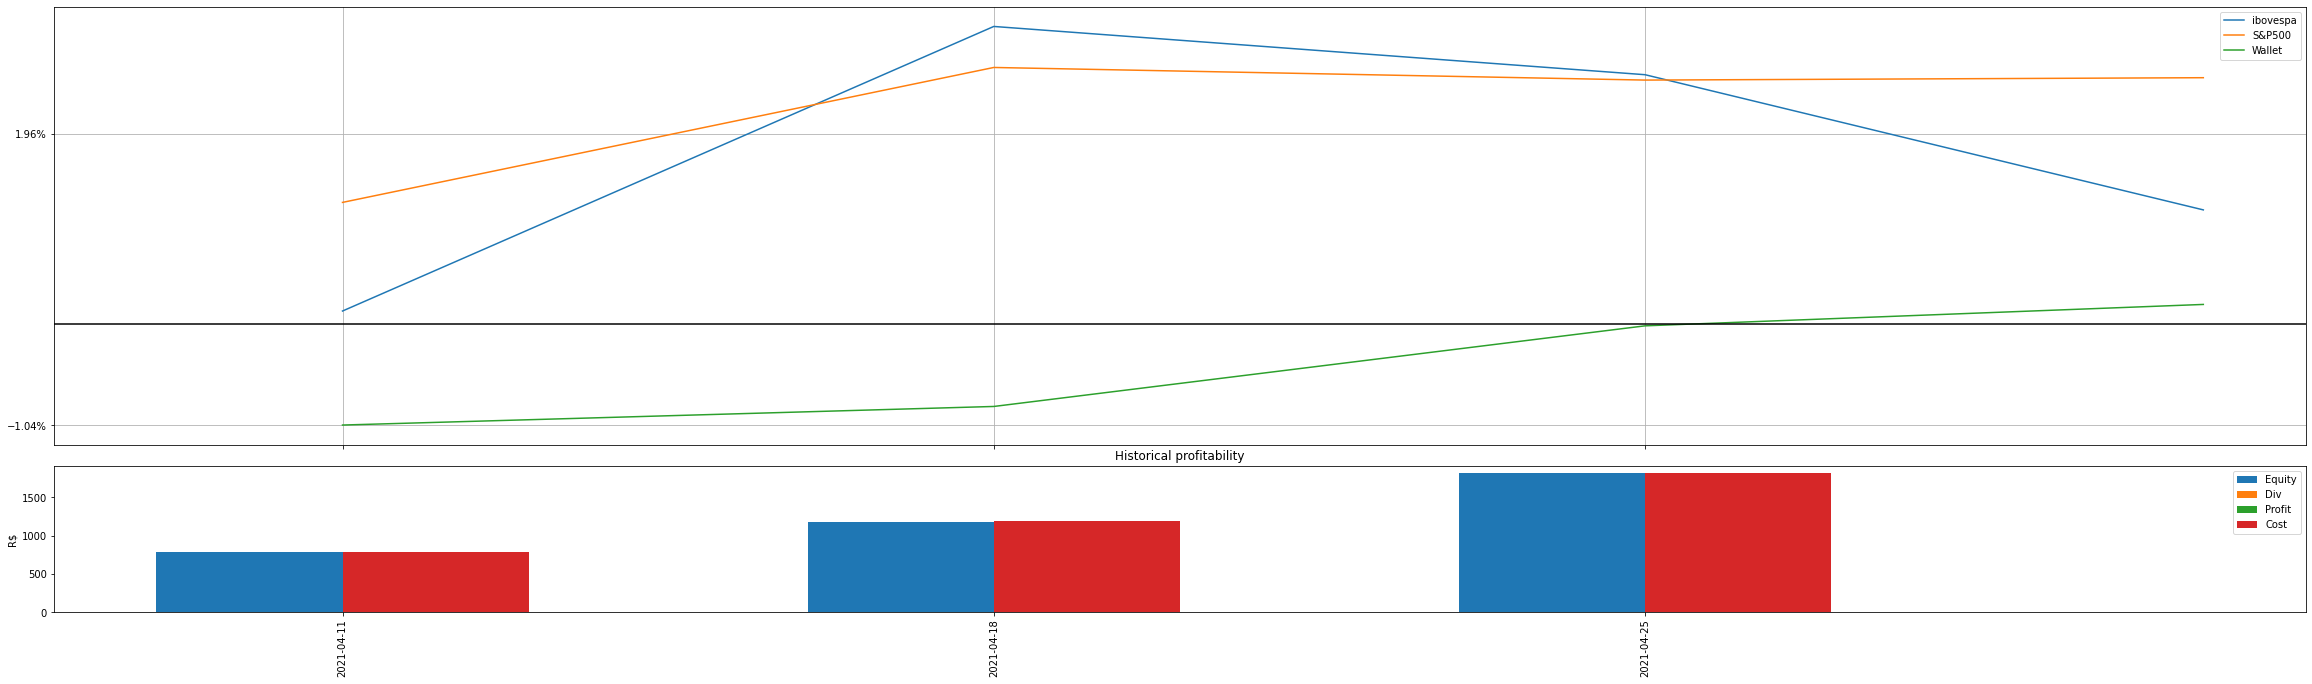

In [21]:
import matplotlib.ticker as mtick

width = 2 if frequency == 'W' else 5     # the width of the bars: can also be len(x) sequence
shift = pd.Timedelta(width/2, unit='d')
fig, ax = plt.subplots(2, 1, figsize=(32, 9), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
fig.tight_layout()

ax[0].plot(histProfDF.Date, histProfDF['%IBOV'], label='ibovespa')
ax[0].plot(histProfDF.Date, histProfDF['%SP500'], label='S&P500')
ax[0].plot(histProfDF.Date, histProfDF['%Profit'], label='Wallet')

minTick = min(histProfDF['%IBOV'].min(), histProfDF['%SP500'].min(), histProfDF['%Profit'].min())
maxTick = max(histProfDF['%IBOV'].max(), histProfDF['%SP500'].max(), histProfDF['%Profit'].max())

ax[0].set_yticks(np.arange(minTick, maxTick, 0.03))
ax[0].axhline(y=0, color='k')
ax[0].grid(True, which='both')
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax[0].legend()

barsDf = histProfDF[:-1]
# ax[1].grid(True, which='both')
ax[1].bar(barsDf.Date - shift, barsDf['Equity'], width, label='Equity')
ax[1].bar(barsDf.Date - shift, barsDf['Div']   , width, bottom=barsDf['Equity'], label='Div')
ax[1].bar(barsDf.Date - shift, barsDf['Profit'], width, bottom=barsDf['Div'] + barsDf['Equity'], label='Profit')
ax[1].bar(barsDf.Date + shift, barsDf['Cost']  , width, label='Cost')
ax[1].legend()
ax[1].set_ylabel('R$')

plt.xticks(barsDf['Date'], rotation=90)
plt.title('Historical profitability')
plt.show()

# Dividends by month

In [23]:
m = int(dt.datetime.today().strftime("%m"))
y = int(dt.datetime.today().strftime("%Y"))
# m=3

divTable = divReader.df
prov = df[df['OPERATION'] == 'DIVIDENDS']

if(not (divTable.empty & prov.empty)):
    divTable = divTable.reset_index()
    divTable = divTable[(divTable['Data de Pagamento'].dt.month == m) & (divTable['Data de Pagamento'].dt.year == y)]

    divTable= pd.merge(divTable, prov, how='inner', on=['DATE', 'SYMBOL', 'PRICE'])

    divTable = divTable[['Data de Pagamento', 'SYMBOL','Total']]
    divTable.columns = ['DATE', 'Ativo', 'R$']
    # divTable = divTable.groupby(['Ativo', 'DATE'])['R$'].sum().reset_index()
    # display(divTable)
    divTable.sort_values('DATE', inplace=True)
    divTable['DATE'] = divTable['DATE'].apply(lambda x: x.strftime('%Y-%m-%d'))
    divTable.loc['Total', 'R$'] = divTable['R$'].sum()
    divTable.fillna(' ', inplace=True)
    display(divTable)


In [24]:
if(not (divTable.empty & prov.empty)):
    pvt = prov.pivot_table(index='Year', columns='Month', values='Total', margins=True, margins_name='Total', aggfunc='sum', fill_value=0)
    sorted_m = sorted(pvt.columns[:-1], key=lambda month: dt.datetime.strptime(month, "%B"))
    sorted_m.append(pvt.columns[-1])
    display(pvt.reindex(sorted_m, axis=1))